In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
%matplotlib inline

In [2]:
data = pd.read_csv('Time_series/sp500_index.csv')
data.head()

,Date,S&P500
0,2014-11-17,2041.32
1,2014-11-18,2051.80
2,2014-11-19,2048.72
3,2014-11-20,2052.75
4,2014-11-21,2063.50


In [3]:
data['Date'] = pd.to_datetime(data['Date'])

#data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2024)]

In [52]:
print(data.shape)
print(data.dtypes)

(2517, 2)
Date      datetime64[ns]
S&P500           float64
dtype: object


In [5]:
data.isnull().values.any()

False

In [6]:
data.describe()

,Date,S&P500
count,2517,2517.000000
mean,2019-11-17 12:23:10.226460160,3308.633588
min,2014-11-17 00:00:00,1829.080000
25%,2017-05-18 00:00:00,2395.960000
50%,2019-11-15 00:00:00,2976.740000
75%,2022-05-17 00:00:00,4173.850000
max,2024-11-15 00:00:00,6001.350000
std,NaN,1053.439161


### Exploratory Data Analysis

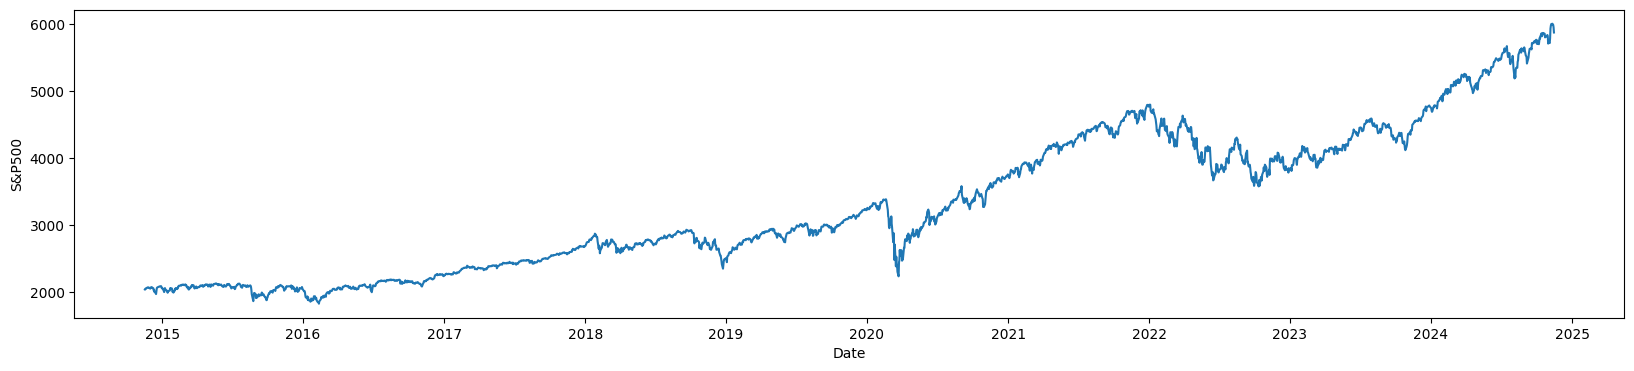

In [4]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])
plt.show()

Abbiamo osservato che nel 2020 c'è un forte picco verso il basso che altera la tendenza nei dati. Analizziamo successivamente in dettaglio cosa succede

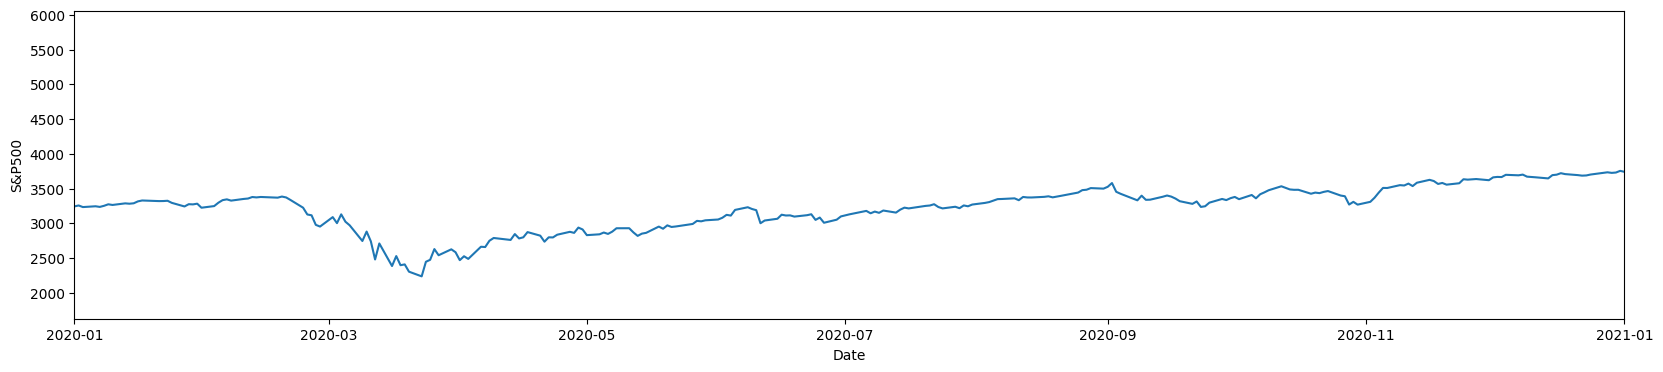

In [8]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

Si può notare che il grande picco verso il basso si può ricollegare all'inizio del COVID, nei mesi di marzo aprile 2020. Successivamente si nota una graduale ripresa

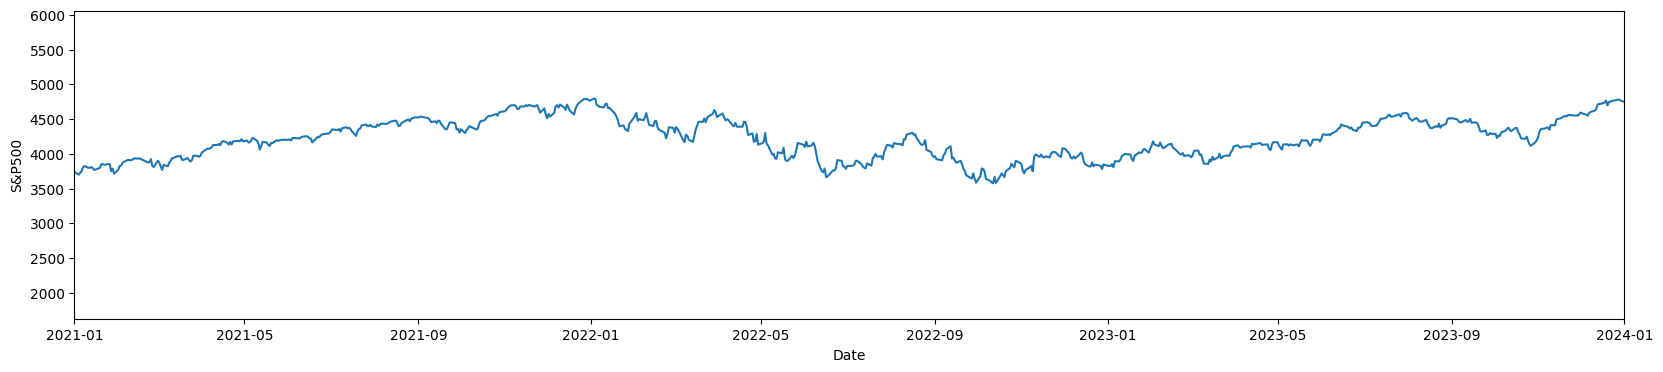

In [9]:
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2024,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data['Date'], data['S&P500'])

un altro momento di picco verso il basso si ha ad inizio 2022 fino al 2023, ricollegabile alla difficile situazione geopolitica tra russia e ucraina

In [10]:
# Rimuovi i dati dal 2020-01-01 al 2020-05-31
#data_filter = data[~((data['Date'] >= '2020-01-01') & (data['Date'] <= '2020-05-31'))]

# Rimuovi dati da anni precedenti al 2022 o successivi al 2023
#data_new = data_filter[~((data_filter['Date'] >= '2022-01-01') & (data_filter['Date'] <= '2023-01-01'))]

data_new = data

NameError: name 'data_new' is not defined

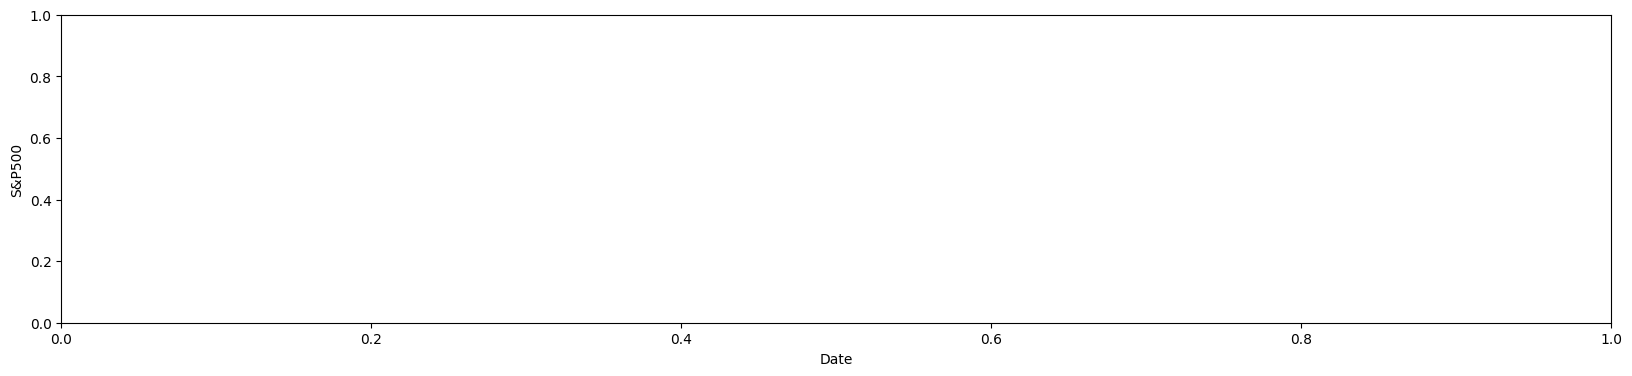

In [4]:
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Date')
ax.set_ylabel('S&P500')
plt.plot(data_new['Date'], data_new['S&P500'])
plt.show()

#### Suddivisione dataset training-test 80/20

In [5]:
# Ordina il DataFrame per la colonna Date
df_data = data.sort_values(by='Date')

# Trova la data di cutoff per gli ultimi 21 giorni
cutoff_date = df_data['Date'].max() - pd.Timedelta(days=300)

# Crea il DataFrame train e test
train_data = df_data[df_data['Date'] <= cutoff_date]
test_data = df_data[df_data['Date'] > cutoff_date]

# Stampa o verifica i DataFrame
print("Train DataFrame:")
print(train_data.head())

print("\nTest DataFrame:")
print(test_data.head())
print(f"Lughezza test: {len(test_data)}")
print(f"Lughezza train: {len(train_data)}")
print(f"Lunghezza totale: {len(df_data)}")

Train DataFrame:
        Date   S&P500
0 2014-11-17  2041.32
1 2014-11-18  2051.80
2 2014-11-19  2048.72
3 2014-11-20  2052.75
4 2014-11-21  2063.50

Test DataFrame:
           Date   S&P500
2308 2024-01-22  4850.43
2309 2024-01-23  4864.60
2310 2024-01-24  4868.55
2311 2024-01-25  4894.16
2312 2024-01-26  4890.97
Lughezza test: 209
Lughezza train: 2308
Lunghezza totale: 2517


## Forecasting

### Stationarity

In [6]:
def test_stationarity(ts):
    stats = ['Test Statistic', 'p-value']
    # Applica il test di Dickey-Fuller aumentato
    df_test = adfuller(ts.dropna())  # Rimuovi i NaN per evitare errori
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])
    
    if df_results.iloc[1] <= 0.05:
        print("La serie è stazionaria (rifiutiamo H0).")
    else:
        print("La serie non è stazionaria (non rifiutiamo H0).")

In [7]:
test_stationarity(train_data['S&P500'])

ADF statistic: -0.28122063386866736
P-value: 0.9281222622756965
La serie non è stazionaria (non rifiutiamo H0).


Questo valore è molto alto, vicino a 1.
Un valore p così elevato indica che non hai evidenza sufficiente per rifiutare l'ipotesi nulla (H₀), che afferma che la serie non è stazionaria. Quindi serie non stazionaria (media, varianza o covarianza variano nel tempo). Per renderla stazonaria applicando le differenze ecc.

In [8]:
train_data['S&P500_diff'] = train_data['S&P500'].diff()
train_data['S&P500_diff'].head()

/var/folders/wz/z6163tcs0v11556rglm8m09h0000gn/T/ipykernel_11844/693865438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['S&P500_diff'] = train_data['S&P500'].diff()


0      NaN
1    10.48
2    -3.08
3     4.03
4    10.75
Name: S&P500_diff, dtype: float64

In [9]:
test_stationarity(train_data['S&P500_diff'])

ADF statistic: -14.976988251819638
P-value: 1.1772773853300556e-27
La serie è stazionaria (rifiutiamo H0).


Questo valore di ADF è ora molto negativo, il che suggerisce una forte evidenza contro l'ipotesi nulla (H₀). Un p-value così basso conferma che possiamo rifiutare l'ipotesi nulla (H₀) con grande confidenza. Concludiamo quindi che la serie è stazionaria dopo la differenziazione.

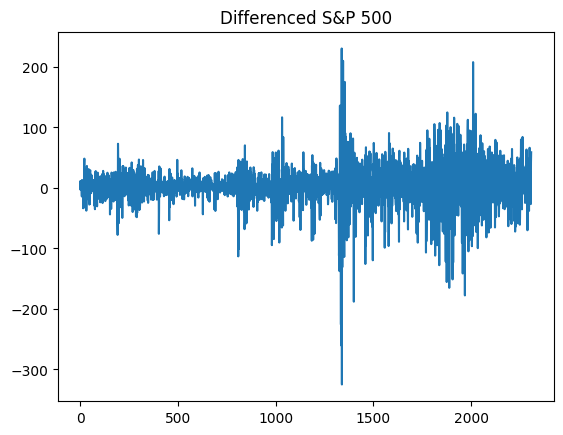

In [10]:
import matplotlib.pyplot as plt
train_data['S&P500_diff'].dropna().plot(title="Differenced S&P 500")
plt.show()

### ACF and PACF graphs

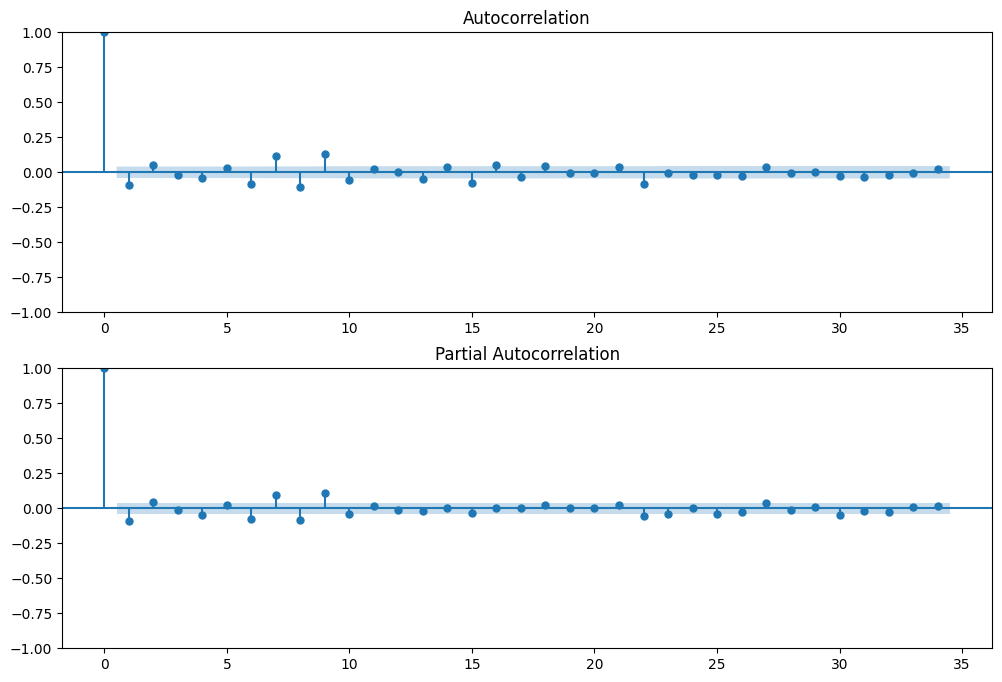

In [11]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['S&P500_diff'][1:],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['S&P500_diff'][1:], ax=ax2)

Possiamo notare una stagionalità intorno ai valori 6/8, quindi quei valori sono correlati con quelli dei 6/8 giorni precedenti (dipendo da quelli)

Primo valore 1 in entrambi perché Il primo lag (ritardo 0) di entrambe le funzioni mostra la correlazione della serie con sé stessa, che è sempre 1 (ovvero perfettamente correlata). Tutti gli altri valori sono prossimi allo zero, Questo comportamento suggerisce che la serie differenziata è quasi rumore bianco:
Un rumore bianco non ha una struttura prevedibile, il che significa che i valori futuri non dipendono linearmente dai valori passati. Possiamo provare quindi un ARIMA con d=1, p=0 (AR) e q=0 (MA).
- (0,1,0) 
- Auto_Arima (2,1,2)

In [12]:
train_data_dropped = train_data.drop('S&P500', axis=1)
train_data_dropped.describe()

,Date,S&P500_diff
count,2308,2307.000000
mean,2019-06-18 17:37:32.339687936,1.213043
min,2014-11-17 00:00:00,-324.890000
25%,2017-03-05 06:00:00,-11.815000
50%,2019-06-19 12:00:00,1.580000
75%,2021-10-01 18:00:00,17.245000
max,2024-01-19 00:00:00,230.380000
std,NaN,36.406169


In [13]:
test_stationarity(train_data_dropped['S&P500_diff'])

ADF statistic: -14.976988251819638
P-value: 1.1772773853300556e-27
La serie è stazionaria (rifiutiamo H0).


In [14]:
train_data_dropped = train_data_dropped.dropna(subset=['S&P500_diff'])

print("\nDataFrame dopo aver eliminato le righe con 'Col1' nullo:")
print(train_data_dropped)


DataFrame dopo aver eliminato le righe con 'Col1' nullo:
           Date  S&P500_diff
1    2014-11-18        10.48
2    2014-11-19        -3.08
3    2014-11-20         4.03
4    2014-11-21        10.75
5    2014-11-24         5.91
...         ...          ...
2303 2024-01-12         3.59
2304 2024-01-16       -17.85
2305 2024-01-17       -26.77
2306 2024-01-18        41.73
2307 2024-01-19        58.87

[2307 rows x 2 columns]


### Fitting Model

In [24]:
# Modello ARIMA
model = ARIMA(train_data_dropped['S&P500_diff'], order=(1, 1, 1))
results_base = model.fit()

# Sommario del modello
print(results_base.summary())

/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            S&P500_diff   No. Observations:                 2307
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11555.225
Date:                Sun, 17 Nov 2024   AIC                          23116.450
Time:                        18:35:13   BIC                          23133.680
Sample:                             0   HQIC                         23122.731
                               - 2307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0938      0.010     -9.415      0.000      -0.113      -0.074
ma.L1         -0.9999      0.012    -81.522      0.000      -1.024      -0.976
sigma2      1314.0931     24.554     53.518      0.0

/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


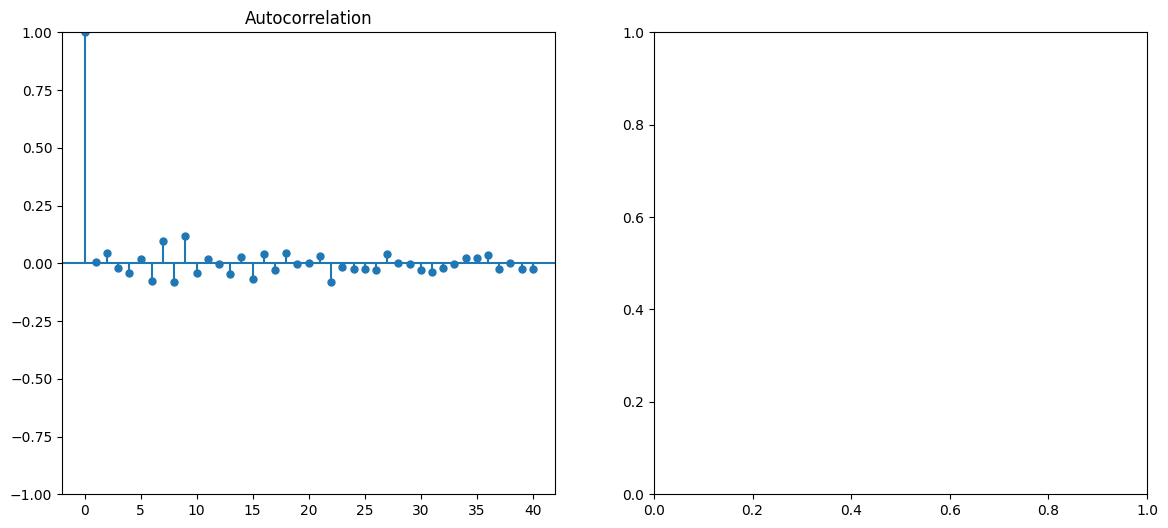

<Figure size 640x480 with 0 Axes>

In [25]:
# Previsione dei residui
from pmdarima import plot_acf, plot_pacf


residuals = results_base.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

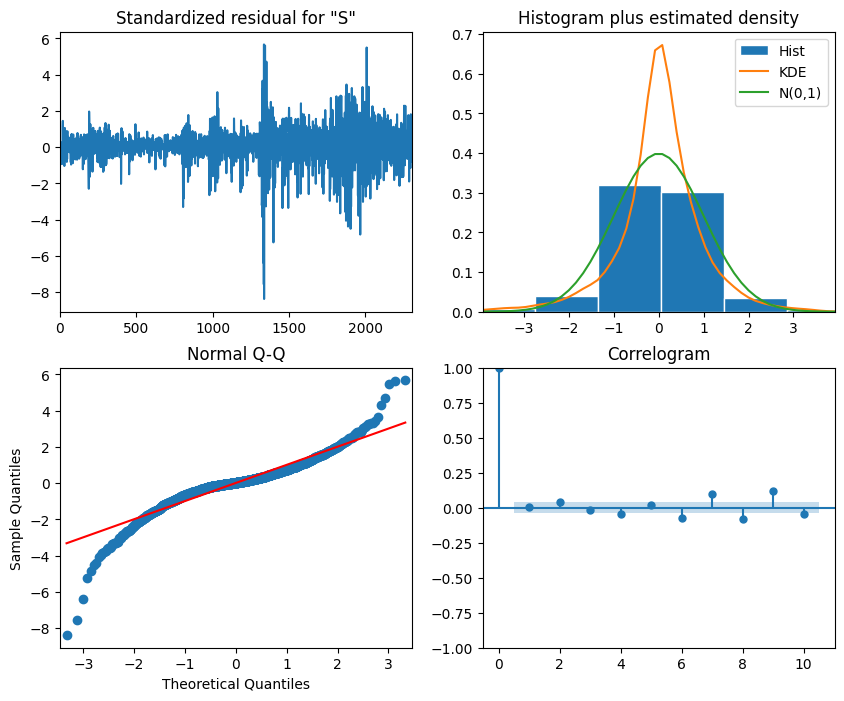

In [26]:
results_base.plot_diagnostics(figsize=(10, 8))
plt.show()

### Test di Ljun-Box sui residui

In [27]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
       lb_stat     lb_pvalue
10   96.772640  2.406579e-16
20  125.490289  2.719773e-17
30  154.757258  9.558645e-19


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
#model = auto_arima(train_data, seasonal=False, stepwise=True, trace=True)
model = auto_arima(train_data_dropped['S&P500_diff'], seasonal=True,m=22, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[22] intercept   : AIC=23030.449, Time=17.18 sec
 ARIMA(0,0,0)(0,0,0)[22] intercept   : AIC=23136.104, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[22] intercept   : AIC=23103.715, Time=2.47 sec
 ARIMA(0,0,1)(0,0,1)[22] intercept   : AIC=23105.084, Time=2.39 sec
 ARIMA(0,0,0)(0,0,0)[22]             : AIC=23136.665, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[22] intercept   : AIC=23028.089, Time=15.59 sec
 ARIMA(2,0,2)(0,0,0)[22] intercept   : AIC=23039.591, Time=2.42 sec
 ARIMA(2,0,2)(0,0,2)[22] intercept   : AIC=23030.229, Time=59.85 sec
 ARIMA(2,0,2)(1,0,0)[22] intercept   : AIC=23027.991, Time=11.49 sec
 ARIMA(2,0,2)(2,0,0)[22] intercept   : AIC=23029.993, Time=60.04 sec
 ARIMA(2,0,2)(2,0,1)[22] intercept   : AIC=23031.837, Time=63.82 sec
 ARIMA(1,0,2)(1,0,0)[22] intercept   : AIC=23102.740, Time=7.22 sec
 ARIMA(2,0,1)(1,0,0)[22] intercept   : AIC=23103.083, Time=4.57 sec
 ARIMA(3,0,2)(1,0,0)[22] intercept   : AIC=23029.596, Time=15.83 se

/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            S&P500_diff   No. Observations:                 2307
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -11513.795
Date:                Sun, 17 Nov 2024   AIC                          23039.591
Time:                        19:01:32   BIC                          23074.053
Sample:                             0   HQIC                         23052.153
                               - 2307                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2124      0.733      1.655      0.098      -0.224       2.649
ar.L1         -1.7645      0.018    -97.971      0.000      -1.800      -1.729
ar.L2         -0.8885      0.017    -52.569      0.0

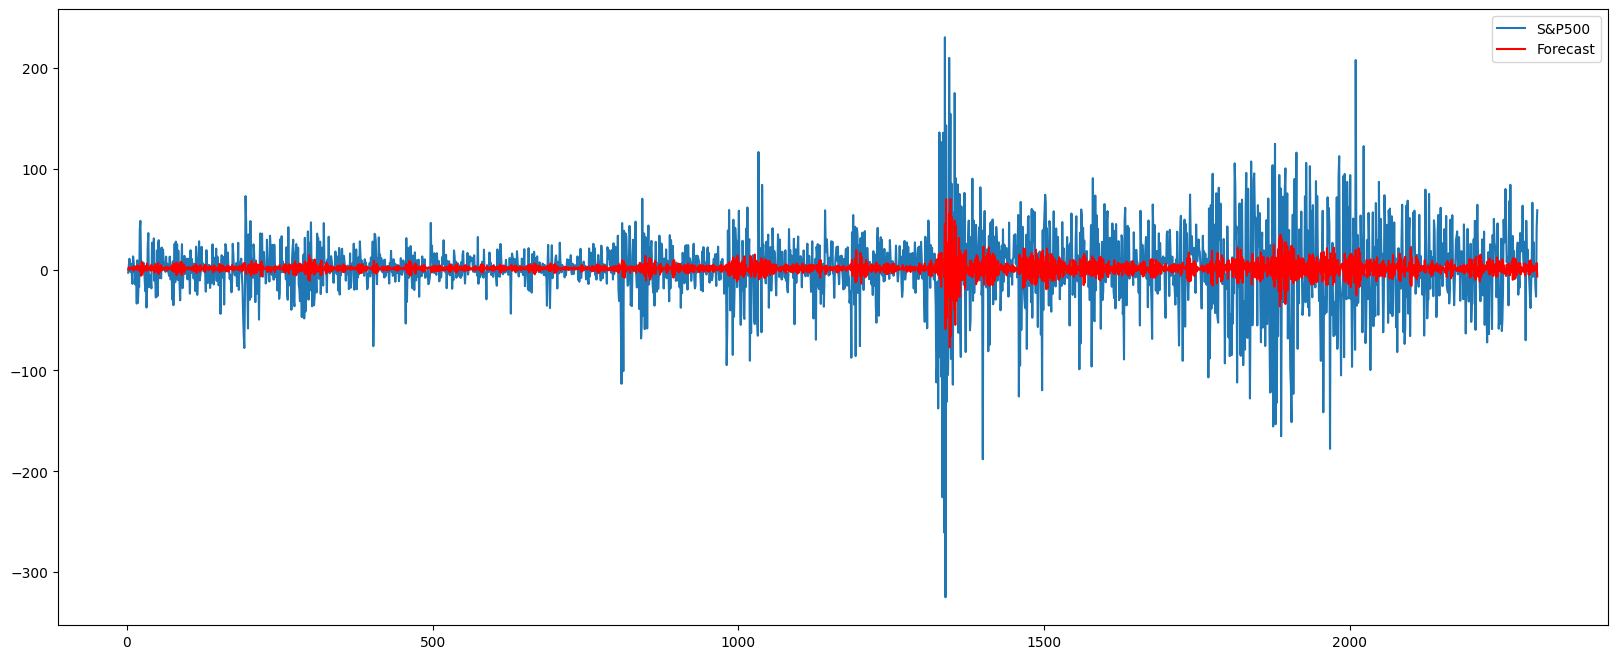

In [90]:
# Fit del modello SARIMA con i parametri trovati da auto_arima
model = ARIMA(train_data_dropped['S&P500_diff'], order=(2,0,2))
results = model.fit()

# Visualizza il grafico
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(train_data_dropped['S&P500_diff'][1:])
plt.plot(results.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

# Mostra il sommario dei risultati
print(results.summary())

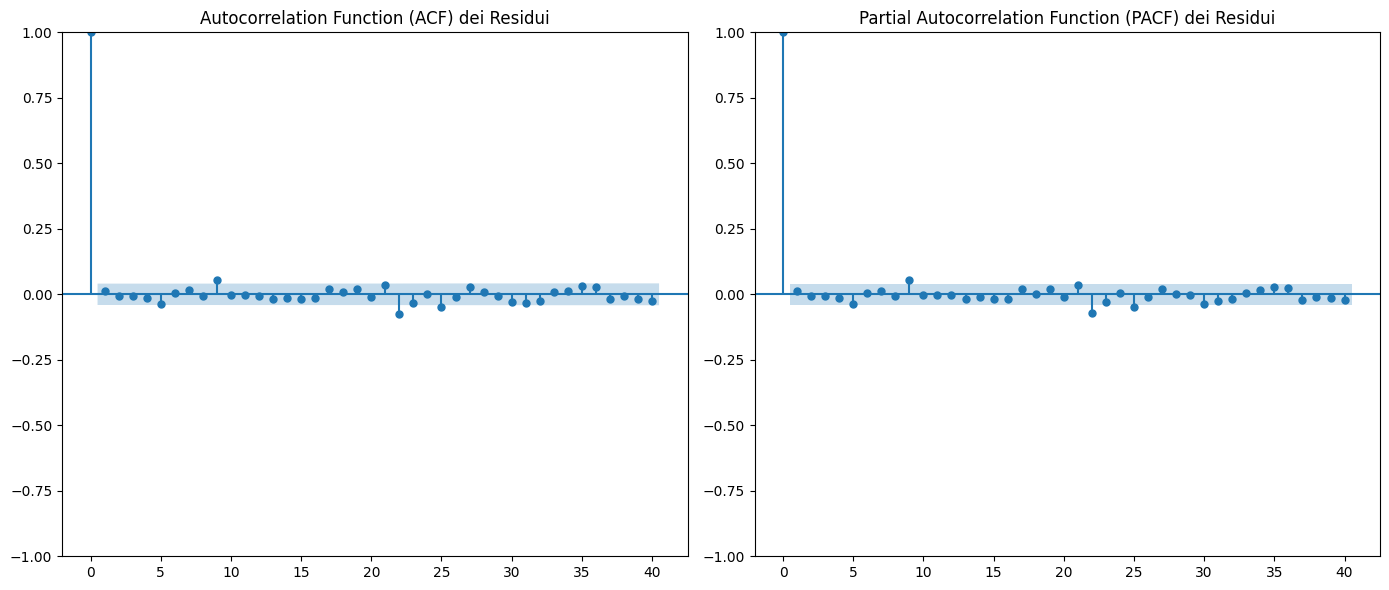

In [91]:
# Previsione dei residui
residuals = results.resid

# Creazione dei grafici ACF e PACF dei residui
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ACF: Autocorrelation Function
plot_acf(residuals, ax=axes[0], lags=40)  # Lags=40 per osservare la correlazione a lungo termine
axes[0].set_title('Autocorrelation Function (ACF) dei Residui')

# PACF: Partial Autocorrelation Function
plot_pacf(residuals, ax=axes[1], lags=40)  # Lags=40 per osservare la correlazione parziale
axes[1].set_title('Partial Autocorrelation Function (PACF) dei Residui')

plt.tight_layout()
plt.show()

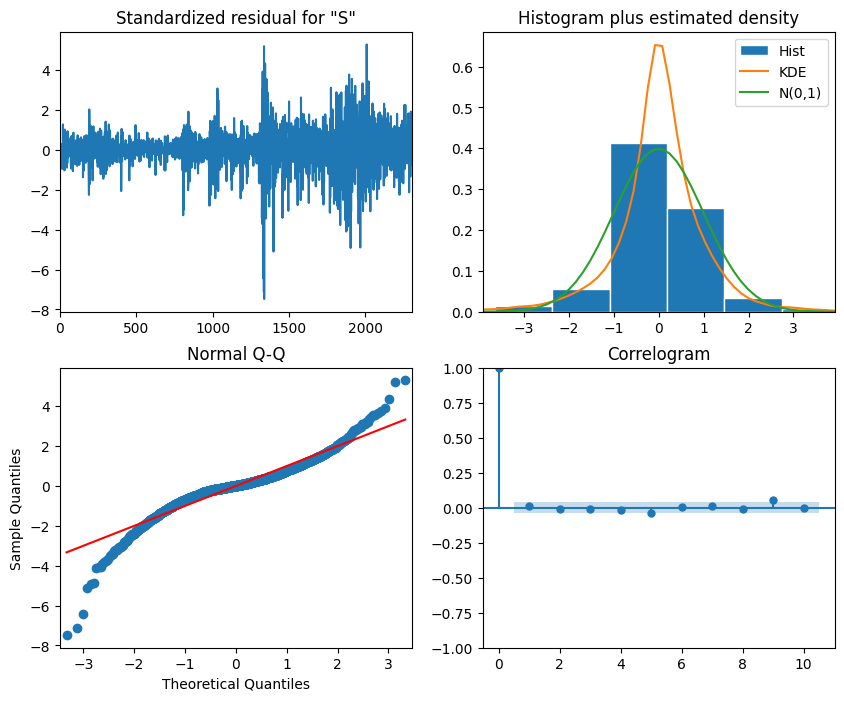

In [92]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

### Test di Ljung-Box

In [105]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10  11.382182   0.328528
20  16.215106   0.703193
30  44.416037   0.043705


I valori di p-value sopra la soglia di 0.05 indicano che i residui non mostrano correlazioni significative e inoltre indica che il modello ha catturato le principali dinamiche della serie temporale. In linea con i risultati di ACF e PACF vicini allo zero.

/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98825D+00    |proj g|=  2.58368D-01


 This problem is unconstrained.



At iterate    5    f=  4.98629D+00    |proj g|=  9.21659D-02

At iterate   10    f=  4.98556D+00    |proj g|=  7.27500D-02

At iterate   15    f=  4.98452D+00    |proj g|=  3.13534D-02

At iterate   20    f=  4.98424D+00    |proj g|=  2.24164D-02

At iterate   25    f=  4.98393D+00    |proj g|=  4.19913D-03

At iterate   30    f=  4.98391D+00    |proj g|=  2.93038D-03

At iterate   35    f=  4.98381D+00    |proj g|=  3.59788D-03

At iterate   40    f=  4.98367D+00    |proj g|=  4.14300D-03

At iterate   45    f=  4.98353D+00    |proj g|=  7.88844D-03

At iterate   50    f=  4.98339D+00    |proj g|=  2.09818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                         
Dep. Variable:                               S&P500_diff   No. Observations:                 2307
Model:             SARIMAX(10, 0, 10)x(2, 0, [1, 2], 22)   Log Likelihood              -11496.689
Date:                                   Sun, 17 Nov 2024   AIC                          23047.378
Time:                                           19:58:39   BIC                          23202.458
Sample:                                                0   HQIC                         23103.909
                                                  - 2307                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4209     15.410      0.027      0.978    

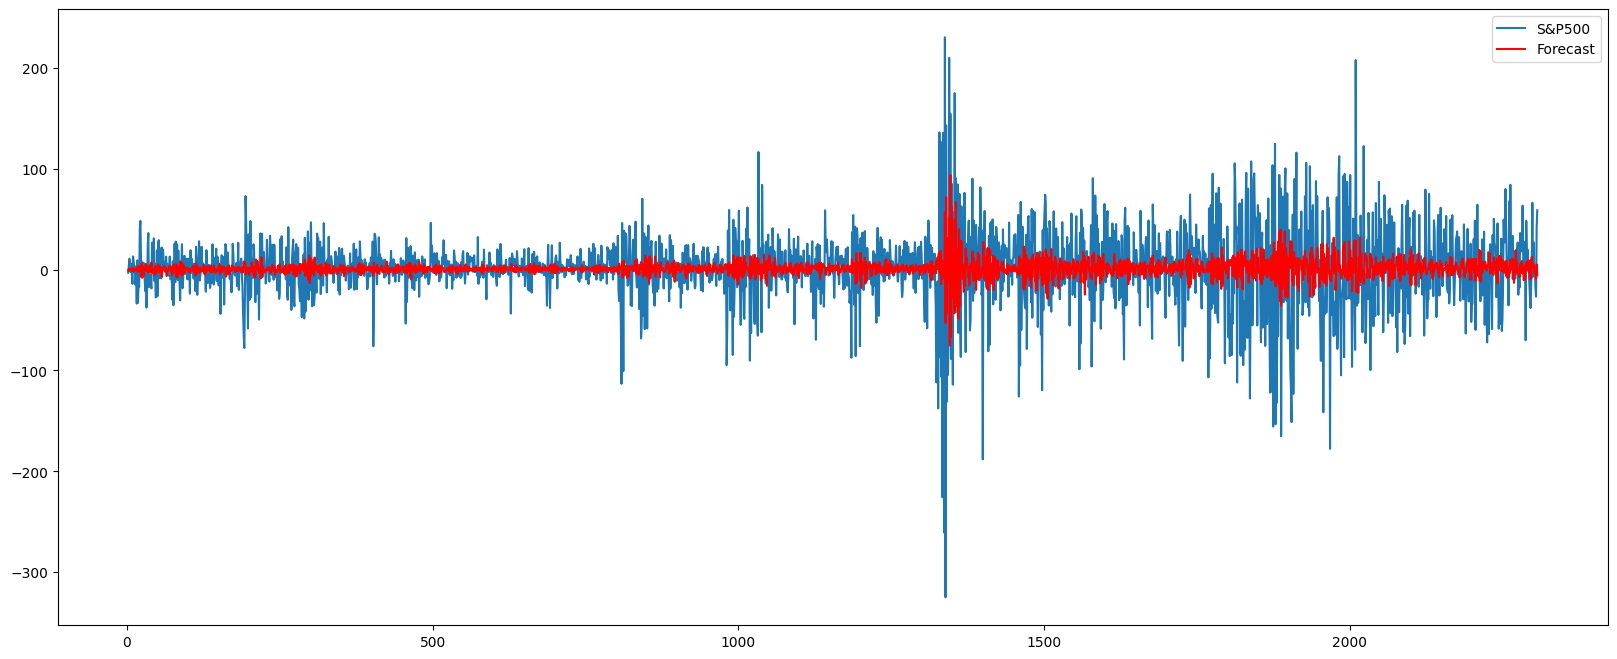

In [15]:
# Fit del modello SARIMA con i parametri trovati da auto_arima
model = SARIMAX(train_data_dropped['S&P500_diff'], order=(10,0,10), seasonal_order=(2,0,2,22), trend='ct')
results_s = model.fit()

# Visualizza il grafico
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(train_data_dropped['S&P500_diff'][1:])
plt.plot(results_s.fittedvalues[1:], color='red')
ax.legend(['S&P500', 'Forecast'])

# Mostra il sommario dei risultati
print(results_s.summary())

In [18]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(results_s.resid, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)

Risultati del test di Ljung-Box:
      lb_stat  lb_pvalue
10   0.966374   0.999853
20   4.119944   0.999941
30  16.025920   0.982523


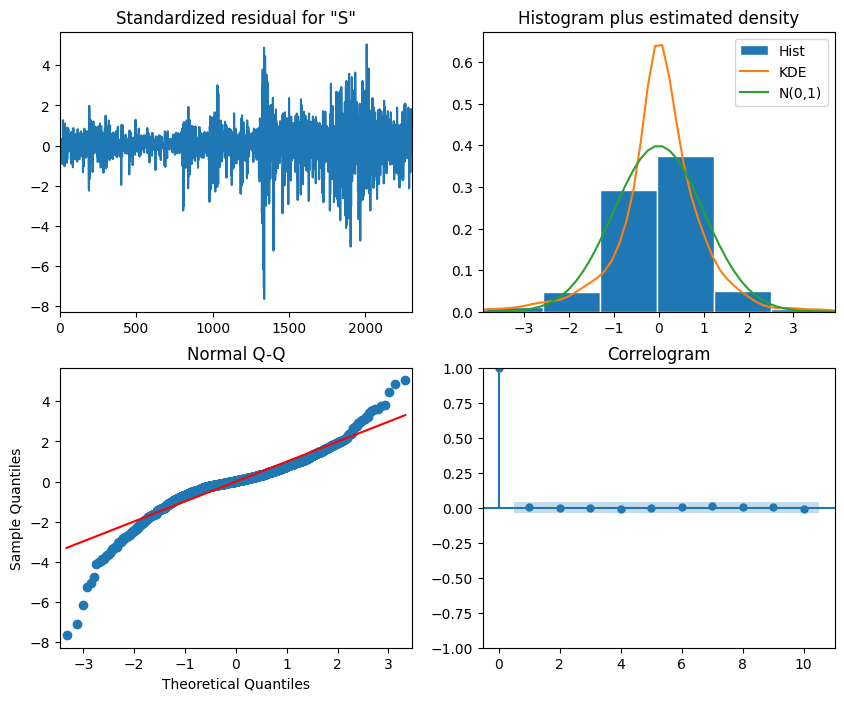

In [19]:
results_s.plot_diagnostics(figsize=(10, 8))
plt.show()

/var/folders/wz/z6163tcs0v11556rglm8m09h0000gn/T/ipykernel_11844/2962493057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['S&P500_diff'] = test_data['S&P500'].diff().dropna()
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


test_data 2308      NaN
2309    14.17
2310     3.95
2311    25.61
2312    -3.19
        ...  
2512     5.81
2513   -17.36
2514     1.39
2515   -36.21
2516   -78.55
Name: S&P500_diff, Length: 209, dtype: float64


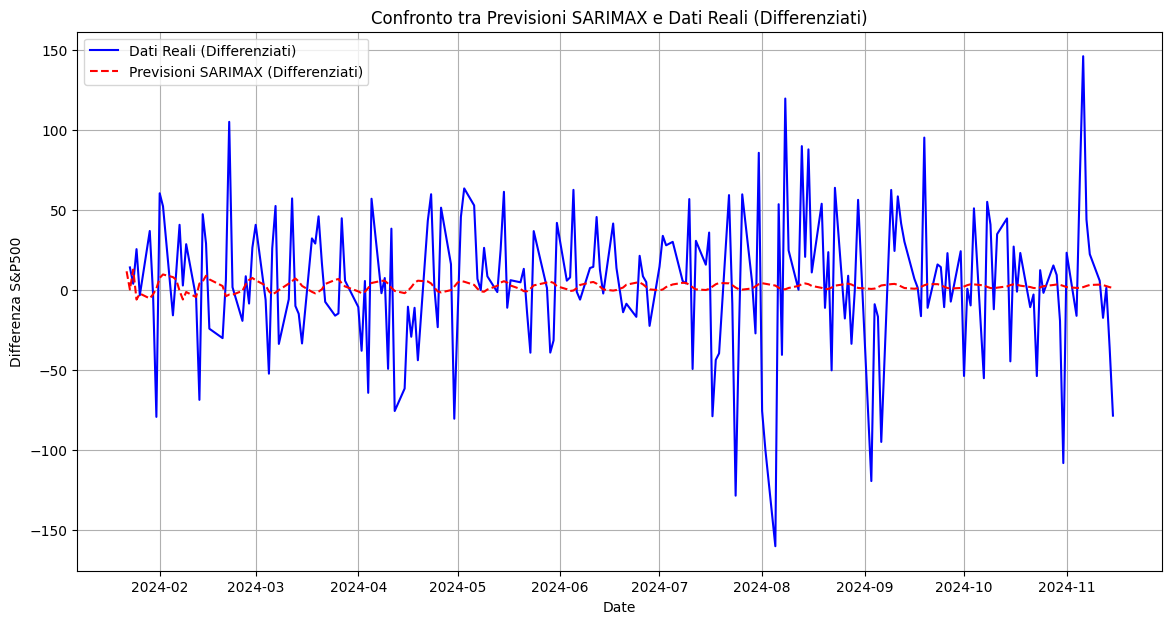

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

test_data['S&P500_diff'] = test_data['S&P500'].diff().dropna()
print('test_data',test_data['S&P500_diff'])


# Fare la previsione con il modello SARIMAX
predictions = results_s.get_forecast(steps=len(test_data['S&P500_diff']))
y_pred = predictions.predicted_mean

y_pred.index = test_data['Date']  # Escludi la prima riga differenziata
y_true = test_data['S&P500_diff']
y_true.index = test_data['Date'] # Escludi la prima riga differenziata


# Step 5: Creazione del grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Dati Reali (Differenziati)', color='blue')
plt.plot(y_pred, label='Previsioni SARIMAX (Differenziati)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Differenza S&P500')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali (Differenziati)')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/wz/z6163tcs0v11556rglm8m09h0000gn/T/ipykernel_11844/1617823735.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['S&P500_diff'] = test_data['S&P500'].diff()
/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


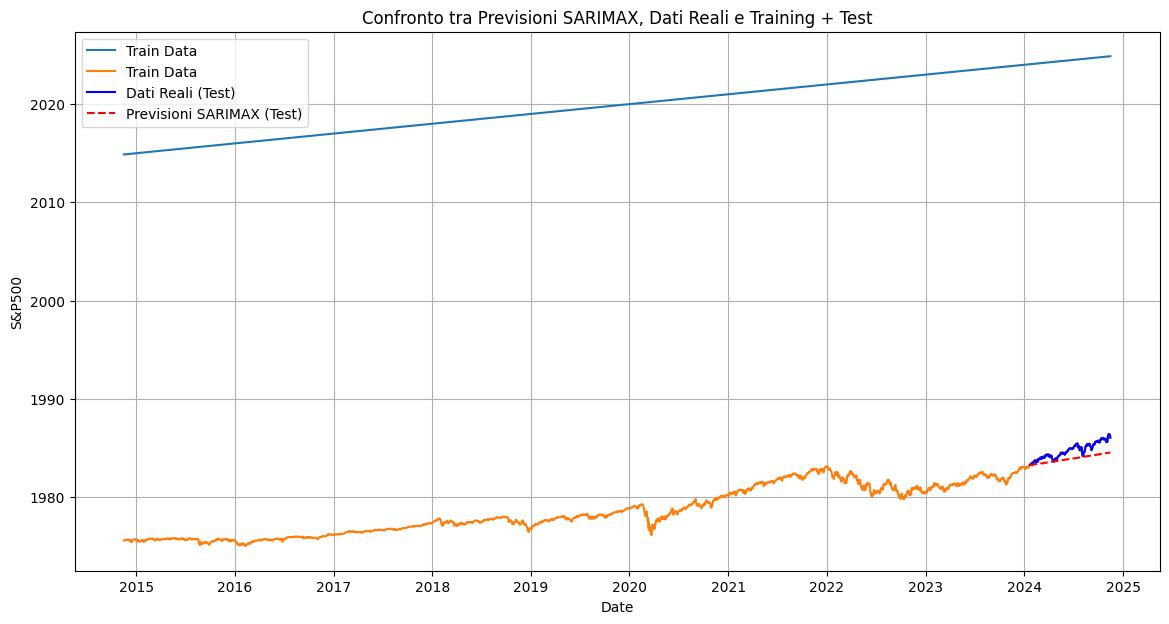

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Differenziazione dei dati di test
test_data['S&P500_diff'] = test_data['S&P500'].diff()

# Step 2: Previsioni con il modello SARIMAX
predictions = results_s.get_forecast(steps=len(test_data['S&P500_diff'].dropna()))
y_pred_diff = predictions.predicted_mean

# Step 3: Ripristinare i dati al dominio originale
# Aggiungi l'ultimo valore noto del training set per ripristinare i dati
last_train_value = train_data['S&P500'].iloc[-1]
y_pred = y_pred_diff.cumsum() + last_train_value

# Ripristinare anche i dati reali
y_true_diff = test_data['S&P500_diff'].dropna()
y_true = y_true_diff.cumsum() + last_train_value

# Allineare l'indice temporale per le previsioni e i dati reali
y_pred.index = test_data['Date'][1:]
y_true.index = test_data['Date'][1:]  # Escludi la prima riga differenziata
data.index = data['Date']

plt.figure(figsize=(14, 7))
plt.plot(data, label="Train Data")
plt.plot(y_true, label='Dati Reali (Test)', color='blue')
plt.plot(y_pred, label='Previsioni SARIMAX (Test)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('S&P500')
plt.title('Confronto tra Previsioni SARIMAX, Dati Reali e Training + Test')
plt.legend()
plt.grid(True)
plt.show()


/Users/lauraferretti/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


2308     0.297463
2309    12.827954
2310    -5.937422
2311    -2.181067
2312    -5.240973
          ...    
2512     3.134755
2513     2.494141
2514     1.807059
2515     1.404370
2516     1.474031
Name: predicted_mean, Length: 209, dtype: float64


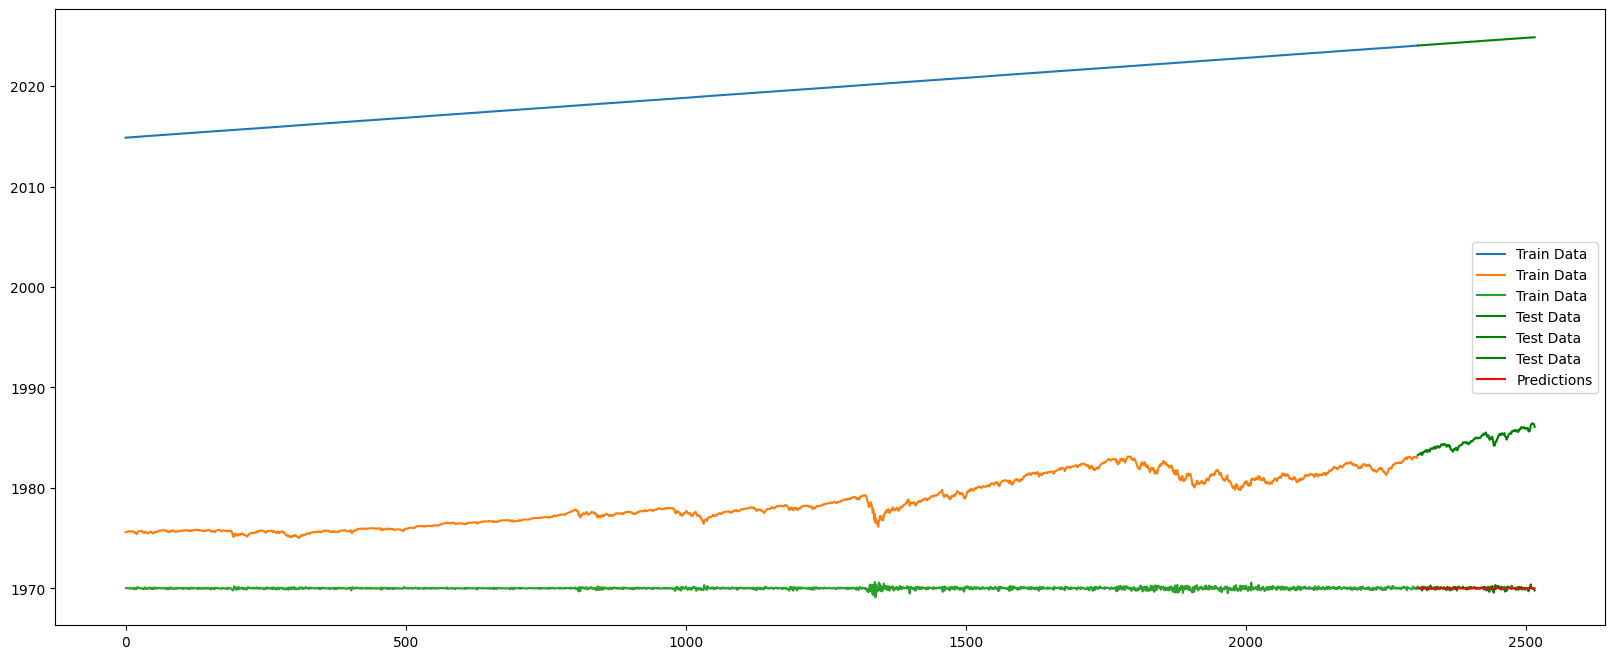

In [37]:
# Previsione per l'intervallo del test set
x_test_pred = results_s.predict(start=len(train_data), end=len(data)-1, dynamic=False)
print(x_test_pred)

# Visualizza i risultati
fig = plt.figure(figsize=(20,8))
plt.plot(train_data, label="Train Data")
plt.plot(test_data, label="Test Data", color='g')  # Aggiungiamo i dati di test per il confronto
plt.plot(range(len(train_data), len(data)), x_test_pred, color='r', label="Predictions")  # Previsioni sul test set
#plt.plot(range(len(train_data)), x_train_pred, color='b', label="Train Predictions")  # Previsioni sul training set
plt.legend()
plt.show()